# Predictions of the Covariances Using the RANS Data

In this notebook We will delve into the study of  'Channel Flow' and 'Couette Flow,' two cornerstone topics in the field of turbulence research, illuminating the complex interplay and structured formations that define turbulent flows. By focusing on the covariances of velocity fluctuations (u'u', v'v', w'w', u'v') and integrating these with Reynolds-Averaged Navier-Stokes (RANS) simulations output variables our goal is to simplify the complex nature of turbulent behaviours into understandable mathematical formulations.

## Import Necessary Libraries

Imports essential Python libraries including the PySINDY Packages.

In [5]:
import numpy as np 
import pandas as pd #
import sys
import matplotlib.pyplot as plt
import pysindy as ps
from pysindy.optimizers import STLSQ
from pysindy import SINDy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from pysindy.optimizers import SR3              #optimizer = SR3(threshold=0.1, nu=1e-2)
from sklearn.linear_model import Lasso          #optimizer = Lasso(alpha=0.1)
from sklearn.linear_model import ElasticNet     #optimizer = ElasticNet(alpha=0.1, l1_ratio=0.5)
from pysindy.optimizers import FROLS            #optimizer = FROLS()
from pysindy.optimizers import STLSQ            #optimizer = STLSQ(threshold=0.01, alpha=1e-5)  alpha is the L2 regularization parameter

## Define Utility Functions

A crucial stage in our project involves the meticulous handling and preprocessing of Direct Numerical Simulation (DNS) data, which provides the foundation for training and validating our PySINDy model. The data is sourced from a comprehensive collection of interpolated DNS profiles, covering a range of Reynolds numbers (Re) that reflect varying turbulence conditions. The following Reynolds numbers and corresponding DNS data files were utilized:

**Channel flow data:** Re = 180, 550, 1000, 2000, 5200.
**Couette flow data:** Re = 93, 220, 500.
Each dataset is instrumental in capturing distinct flow characteristics essential for a robust turbulence model.

**Data Integrity Checks:**
To ensure the integrity and quality of the DNS data, several functions were defined and implemented:

**check_for_nans_and_infs:** This function scans the dataset for any NaN (Not a Number) or infinite values, which may indicate missing or erroneous data. Encountering such values triggers a warning, signaling the need for further investigation or data cleaning.
**verify_data:** It asserts the absence of NaNs and infinities in our feature matrix (X) and the target matrix (X_dot), guaranteeing that the subsequent analysis is grounded on valid numerical data.
remove_near_constant_features: Near-constant features are filtered out to enhance the model's ability to focus on relevant dynamics. This function identifies and removes data columns that do not exhibit significant variation, determined by a predefined threshold.                                      
**calculate_vif:** The Variance Inflation Factor (VIF) is computed for each feature to diagnose multicollinearity. Features with high VIF are indicative of redundancy and may be considered for removal to improve model performance and interpretability.
The prepared and vetted data provides a reliable basis for training our predictive model, which aims to unveil the intricate relationships within turbulent flows and contribute significantly to the field of fluid dynamics.

In [6]:

# Load DNS results data
dns_data_filenames = {
    180: 'Unnormalized_interpolated_data\Channel_180_unnormalized.csv',
    550: 'Unnormalized_interpolated_data\Channel_550_unnormalized.csv',
    1000: 'Unnormalized_interpolated_data\Channel_1000_unnormalized.csv',
    2000: 'Unnormalized_interpolated_data\Channel_2000_unnormalized.csv',
    220:  'Unnormalized_interpolated_data\Couette_220100_unnormalized.csv',
    93:  'Unnormalized_interpolated_data\Couette_93100_unnormalized.csv',
    500: 'Unnormalized_interpolated_data\Couette_500100_unnormalized.csv',
    5200: 'Unnormalized_interpolated_data\Channel_5200_unnormalized.csv'
}

# Function to check for NaNs and infinite values in the DataFrame
def check_for_nans_and_infs(dataframe, step_description):
    """
    Check for NaNs and infinite values in a DataFrame.
    
    Parameters:
    - dataframe: The DataFrame to check.
    - step_description: A description of the processing step for logging.
    """
    if dataframe.isnull().values.any():
        print(f"Warning: NaNs found after {step_description}")
    if np.isinf(dataframe.values).any():
        print(f"Warning: Infinite values found after {step_description}")

# Function to verify data integrity
def verify_data(X, X_dot):
    """
    Verify that the data matrices do not contain NaNs or infinite values.
    
    Parameters:
    - X: Feature matrix.
    - X_dot: Target matrix.
    """
    assert not np.isnan(X).any(), "X contains NaNs"
    assert not np.isinf(X).any(), "X contains infinities"
    assert not np.isnan(X_dot).any(), "X_dot contains NaNs"
    assert not np.isinf(X_dot).any(), "X_dot contains infinities"

# Function to remove near-constant features
def remove_near_constant_features(X, threshold=1e-7):
    """
    Remove near-constant features from the data.
    
    Parameters:
    - X: Feature matrix.
    - threshold: Threshold to determine if a feature is near-constant.
    
    Returns:
    - A tuple of the filtered feature matrix and the mask of selected features.
    """
    std_dev = np.std(X, axis=0)
    non_constant_features = std_dev > threshold
    return X[:, non_constant_features], non_constant_features

# Function to calculate Variance Inflation Factor (VIF)
def calculate_vif(X, feature_names):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature.
    
    Parameters:
    - X: Feature matrix.
    - feature_names: List of feature names.
    
    Returns:
    - A DataFrame with the features and their corresponding VIF.
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = feature_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data
    


## Feature Engineering and Model Training

Selected for their turbulence characteristics, Reynolds numbers **[5200, 1000, 180 for channel flow; 93, 220 for Couette flow]** formed the training set, capturing a wide range of fluid dynamics. Key turbulence parameters like **(u'u', v'v', w'w', u'v')** along with their gradients, were chosen for their fundamental roles in the momentum and energy transport within the flow.
A Polynomial Library of degree 5 and the FROLS optimizer **(set with α=0.05 and max iterations = 7)** structured the SINDy model's feature space. This approach aimed to balance complexity with computational efficiency.
DNS datasets were processed to construct comprehensive training matrices, **X** and **Xdot**, consolidating features and their derivatives respectively. The SINDy model was then trained on this dataset, fitting it to the intrinsic patterns of turbulence. The resulting equations, outputted by **model.print()** , encapsulate the discovered dynamics governing the turbulent flows.

In [7]:
# Define the training channels and the features to analyze
train_channels = [5200, 1000, 180, 93, 220]
parameters_to_analyze = ['u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'']

# Create a Polynomial Library with degree 5 and the FROLS optimizer
feature_library = ps.PolynomialLibrary(degree=5)
optimizer = FROLS(alpha=0.05, max_iter=7)

# Define the features and feature names for SINDy
features = ['dxdy', 'zvel_x', 'xvel_x', 'dzdy', 't_visc', 'Re_tau', 'nu', 'u_tau', 'DNS_k']
feature_names = features + ['u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'']

# Initialize lists to collect training data
X_train_combined = []
X_dot_train_combined = []

# Process DNS data for each channel
for channel in train_channels:
    filename = dns_data_filenames[channel]
    dns_data = pd.read_csv(filename)
    
    # Extract the differentiation variable and features
    t = dns_data['y'].values
    X = dns_data[features].values
    covariances = dns_data[parameters_to_analyze].values
    X_dot = covariances
    
    # Append data for combined training
    X_train_combined.append(X)
    X_dot_train_combined.append(X_dot)

# Combine all training data
X_train_combined = np.vstack(X_train_combined)
X_dot_train_combined = np.vstack(X_dot_train_combined)

# Initialize and fit the SINDy model
model = SINDy(optimizer=optimizer, feature_library=feature_library, feature_names=feature_names)
model.fit(X_train_combined, x_dot=X_dot_train_combined)
model.print()

c:\Users\elkar\Downloads\Final_Approach\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.43767e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\elkar\Downloads\Final_Approach\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.43539e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\elkar\Downloads\Final_Approach\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.4051e-86): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\elkar\Downloads\Final_Approach\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.04074e-36): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=T

(dxdy)' = 1.176 DNS_k + -1.655 t_visc Re_tau nu + 134.711 dxdy^2 nu^2 + 18998.796 DNS_k^4 + 102817.778 dxdy^2 t_visc nu DNS_k + 746.893 dxdy^2 t_visc DNS_k^2
(zvel_x)' = 0.297 DNS_k + -81141.214 dxdy^2 t_visc nu DNS_k + -85.605 dxdy^2 t_visc u_tau DNS_k + 29.391 t_visc Re_tau^2 nu^2
(xvel_x)' = 0.555 DNS_k + -78092.689 dxdy^2 t_visc nu DNS_k + -508.328 dxdy^2 nu DNS_k^2 + -205.272 t_visc Re_tau DNS_k^3
(dzdy)' = -0.989 dxdy t_visc + -351.066 dxdy t_visc DNS_k^2 + -22308.210 dxdy nu^2 DNS_k + -3145.319 t_visc DNS_k^3 + 27241.033 dxdy nu u_tau DNS_k^2


## Feature Engineering and Model Training

The validation phase involved a systematic comparison between the model predictions and actual DNS data. For each channel flow represented in our dataset, we performed the following steps:

**Data Reading:** DNS data files were read into the workspace for each channel to extract the spatial coordinate y and the corresponding flow features and covariances.
Feature Extraction: From the DNS data, we retrieved the matrix of features **X** and the actual covariance derivatives **Xdot** , essential for the subsequent prediction phase.
**Prediction:** Utilizing the previously trained SINDy model, we predicted the derivatives of the covariance terms, yielding a set of results that could be directly compared to the true DNS data.
**Visualization:** To visually assess the model's accuracy, plots were generated for each term of interest. These plots showcased the actual DNS data alongside the model's predictions, facilitating an immediate and clear comparison.

Each plot was configured to ensure clarity, with labels for both the actual and predicted values. The goal was to not only confirm the model's accuracy but also to identify any discrepancies that might indicate areas for further refinement.

By iterating through this process for each channel, we gathered comprehensive validation results, which were then critically analyzed to assess the model's performance across different flow conditions and to substantiate the generalizability of our model.


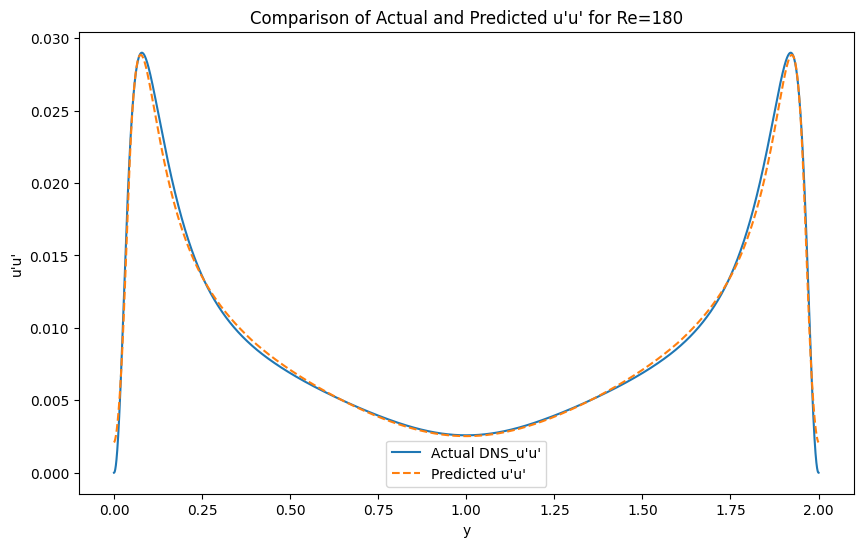

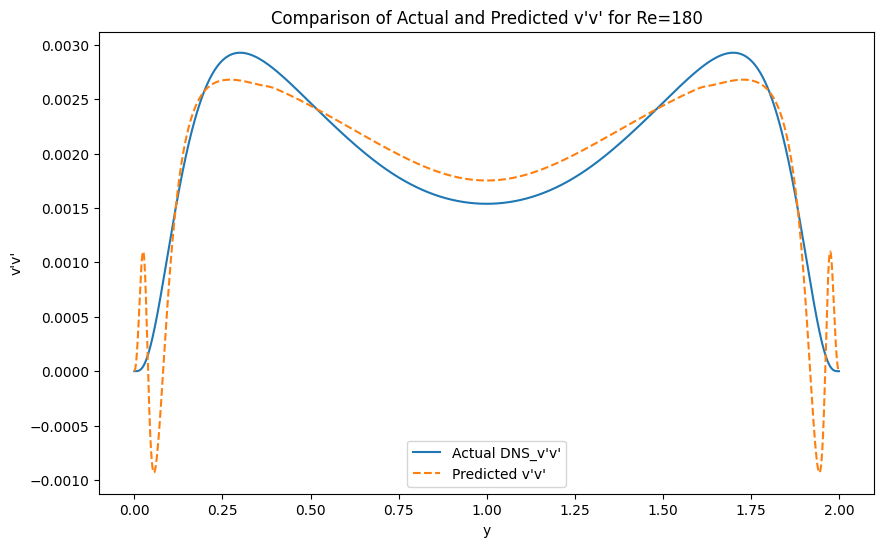

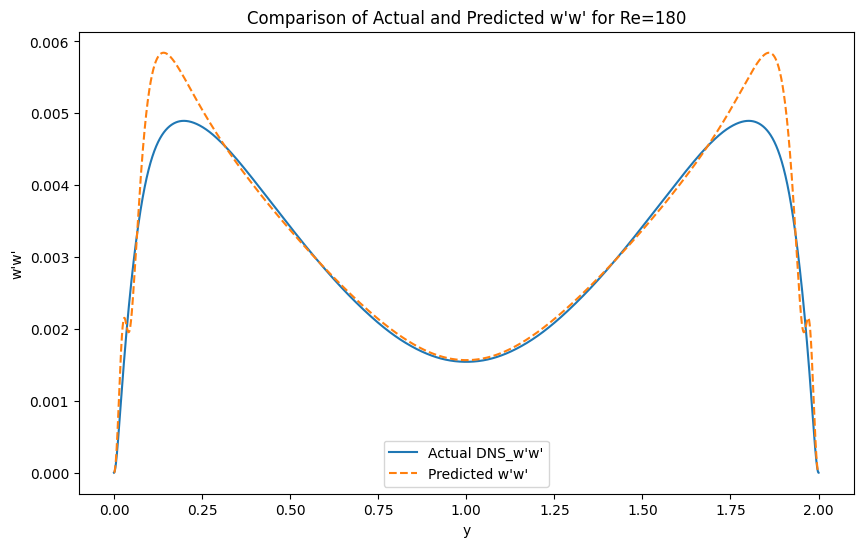

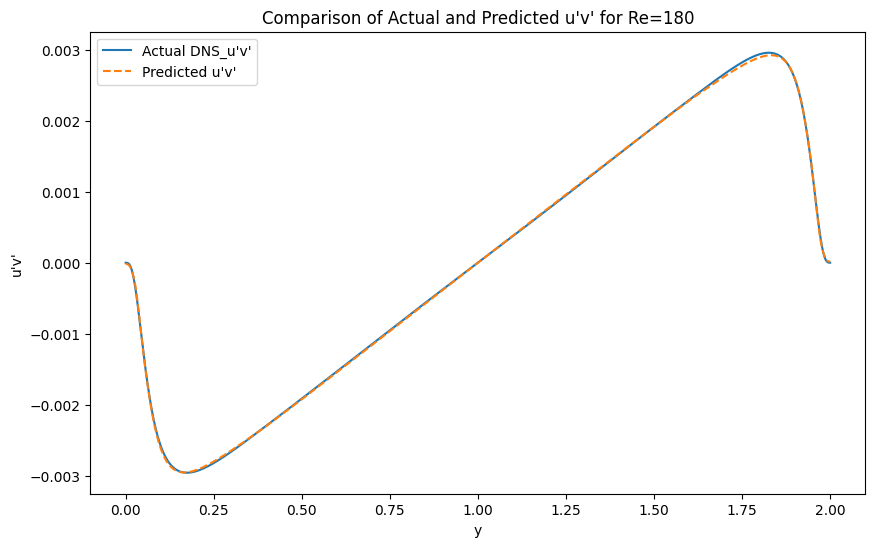

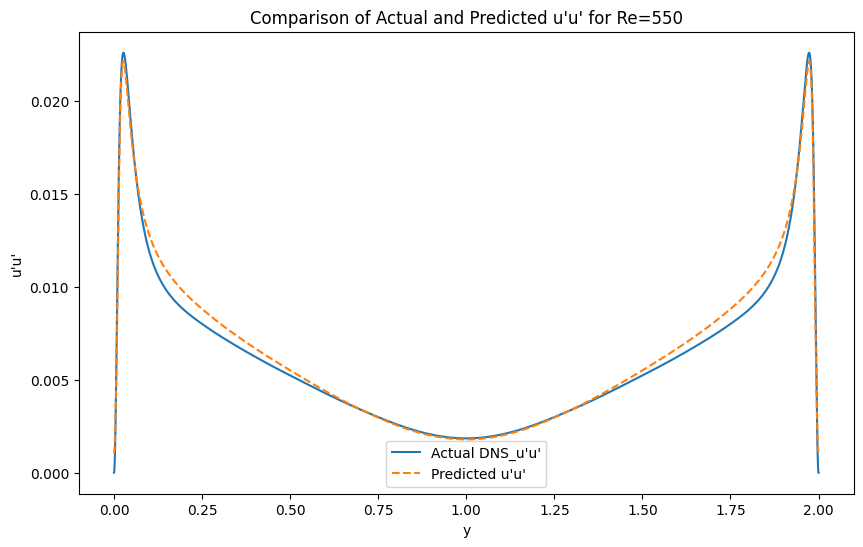

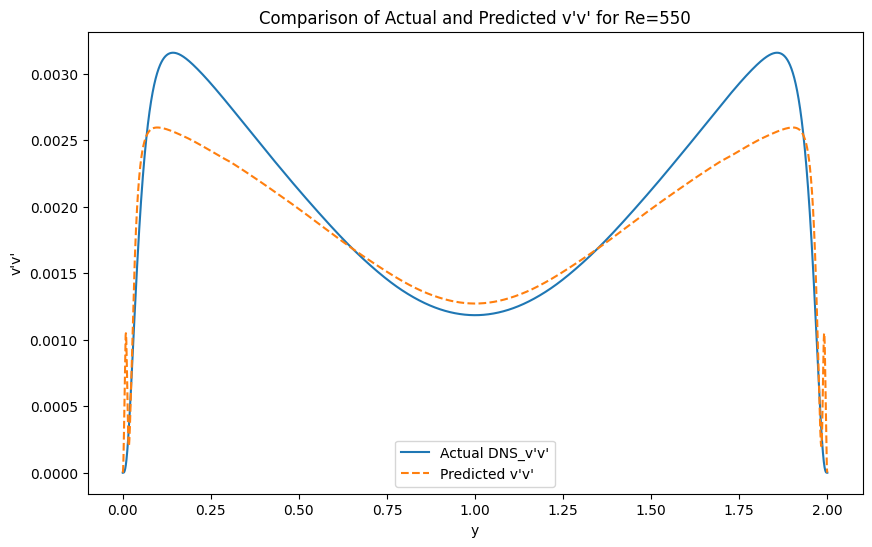

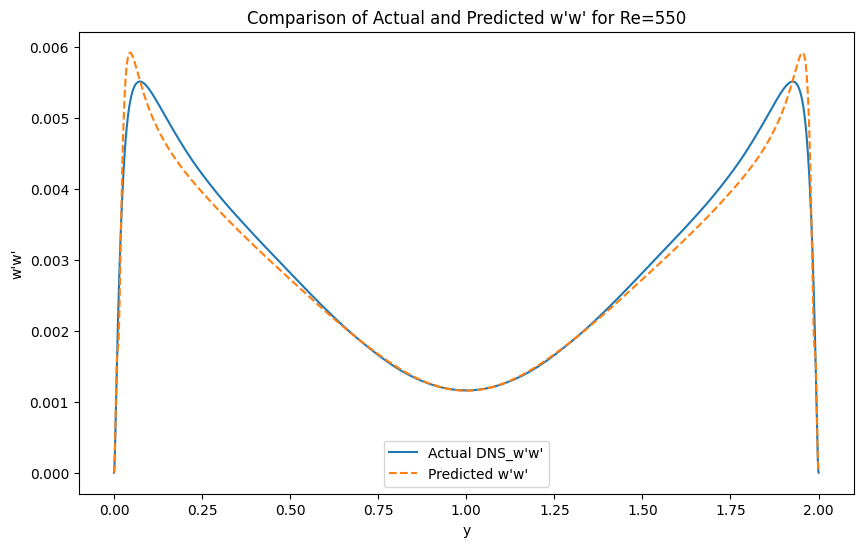

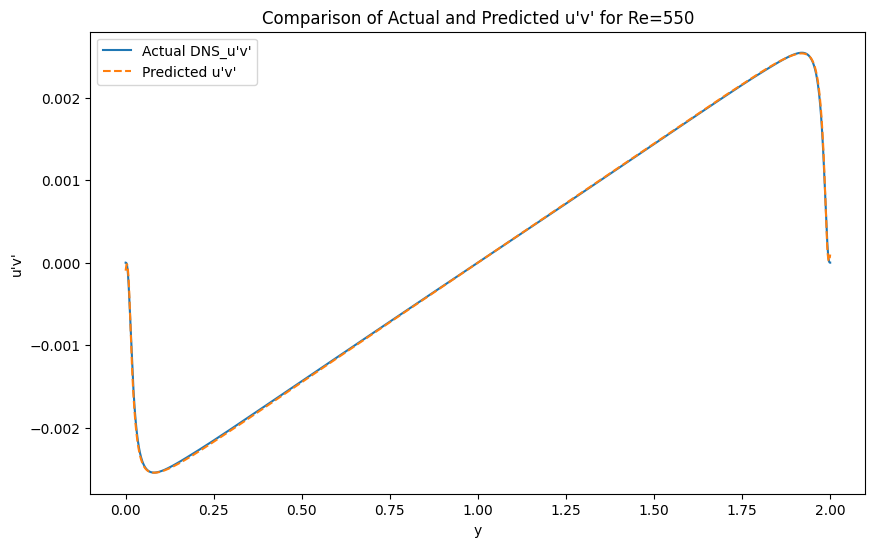

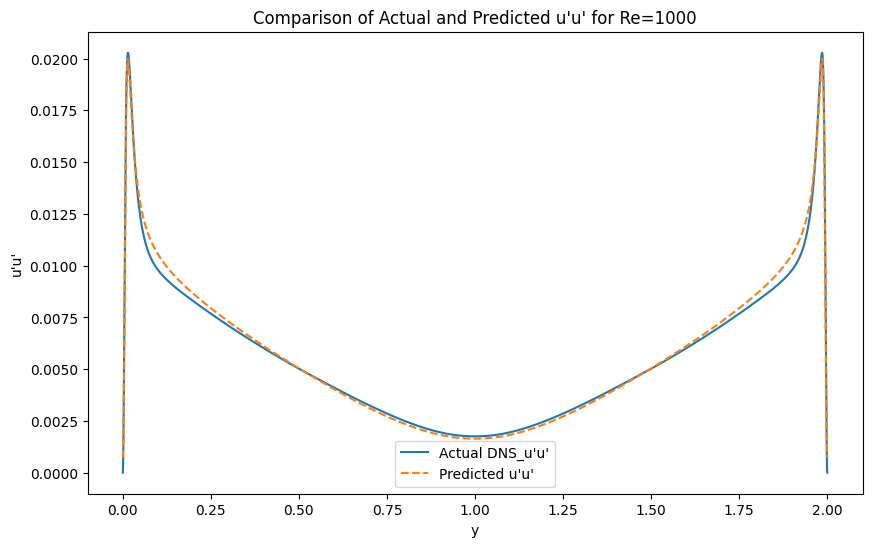

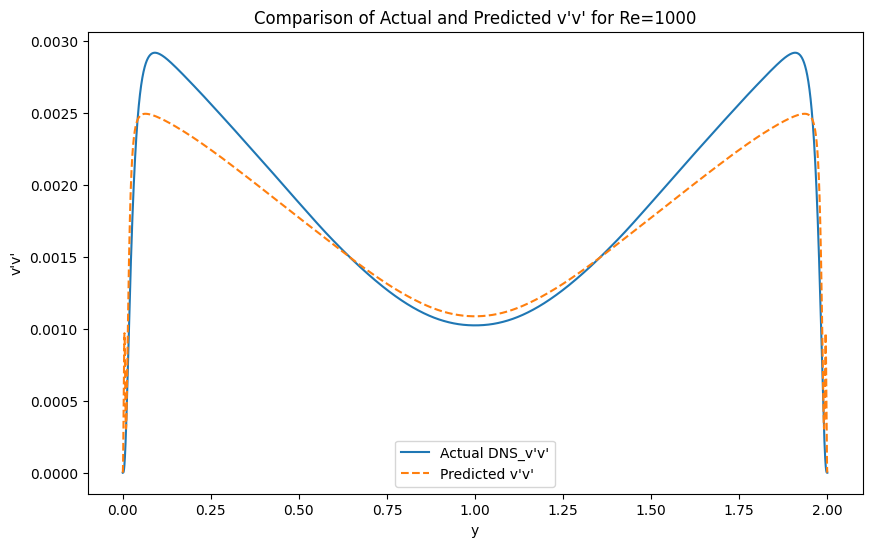

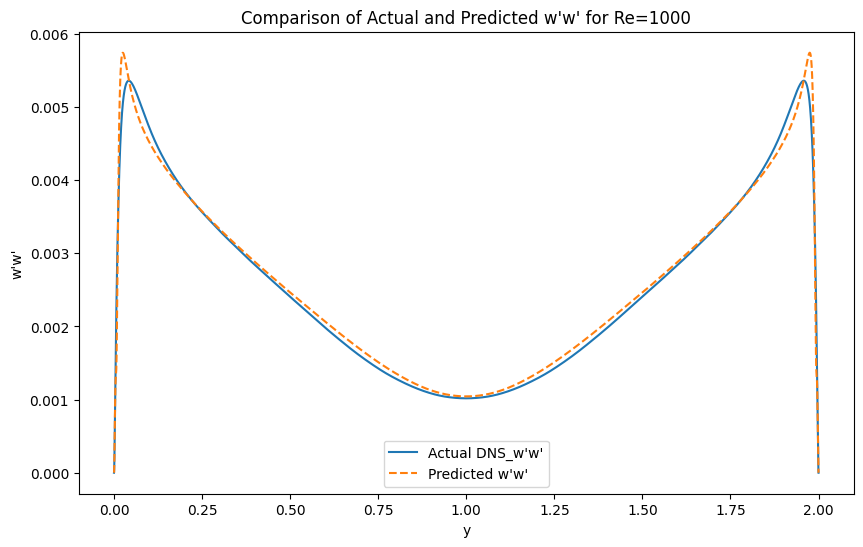

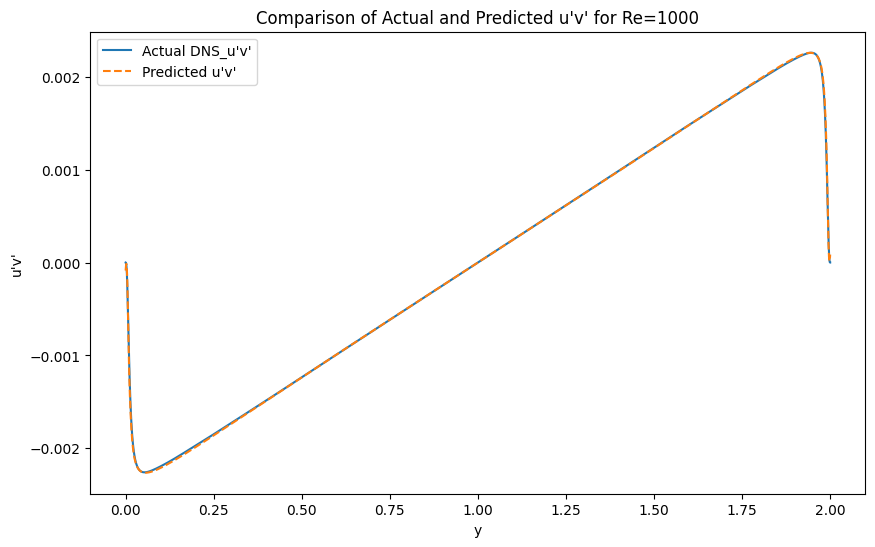

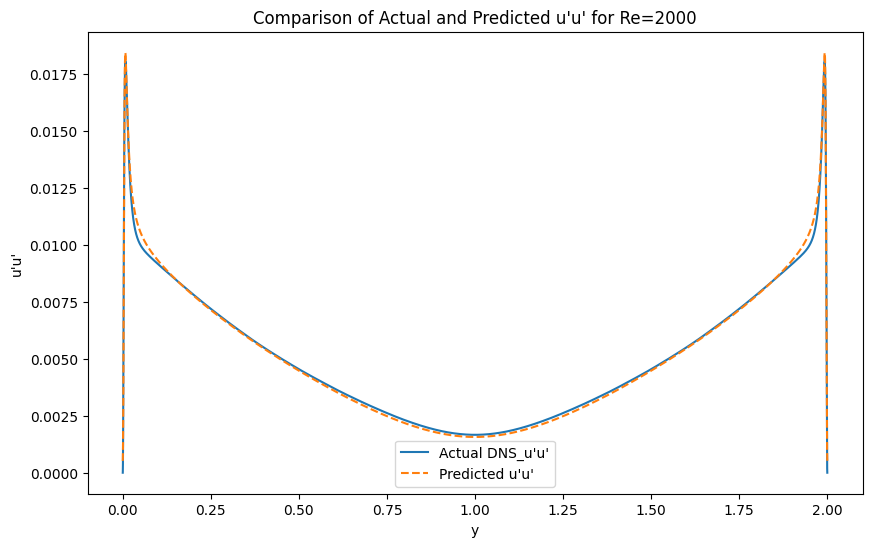

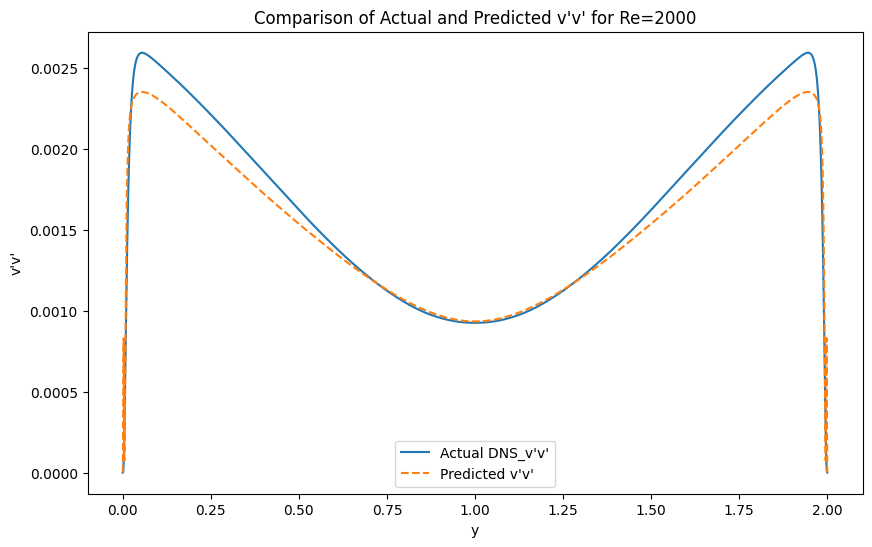

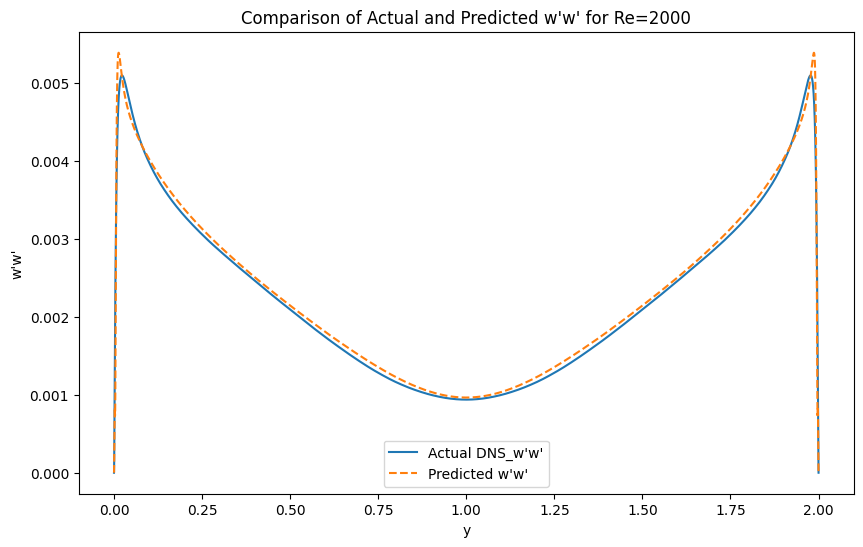

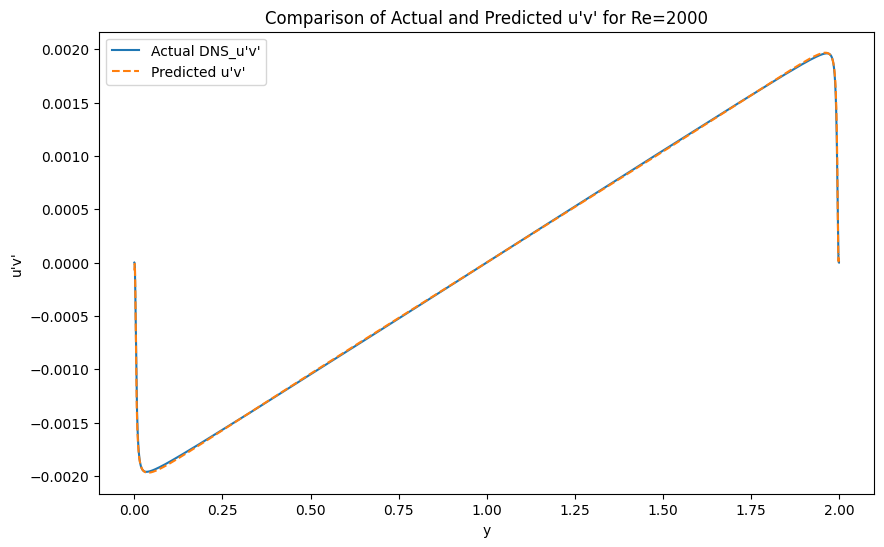

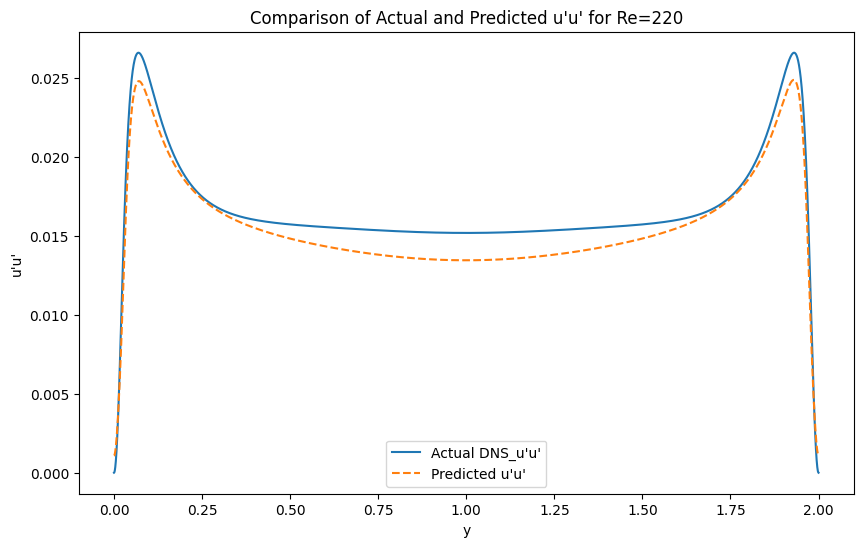

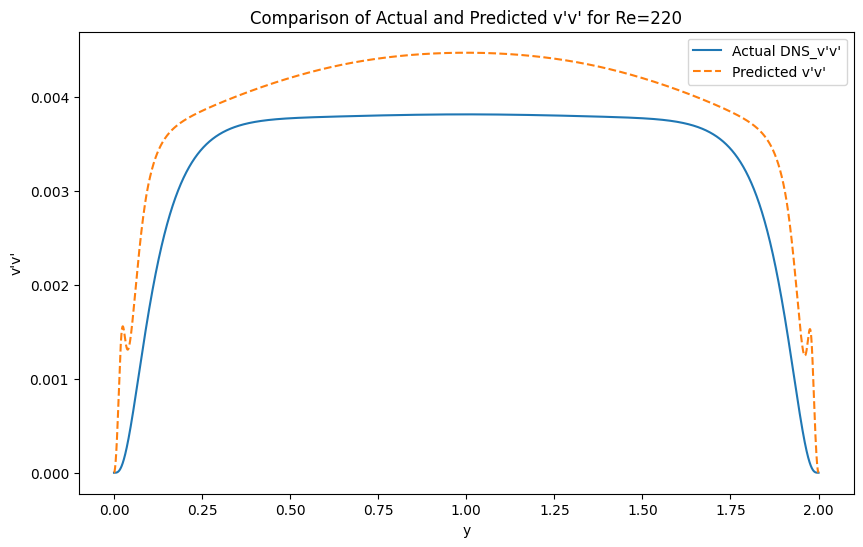

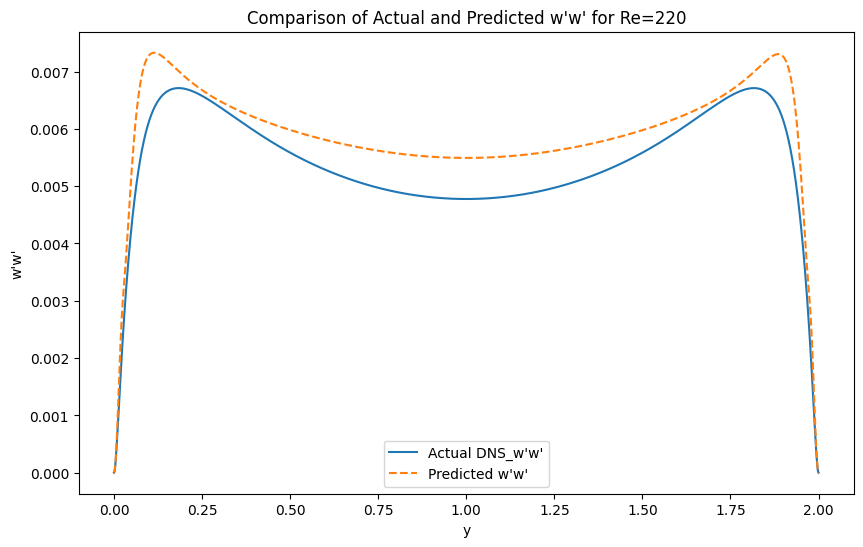

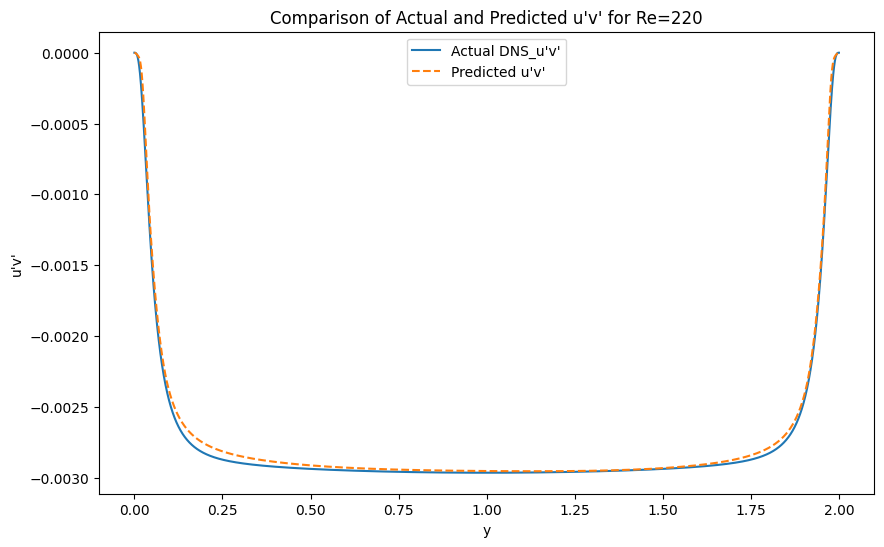

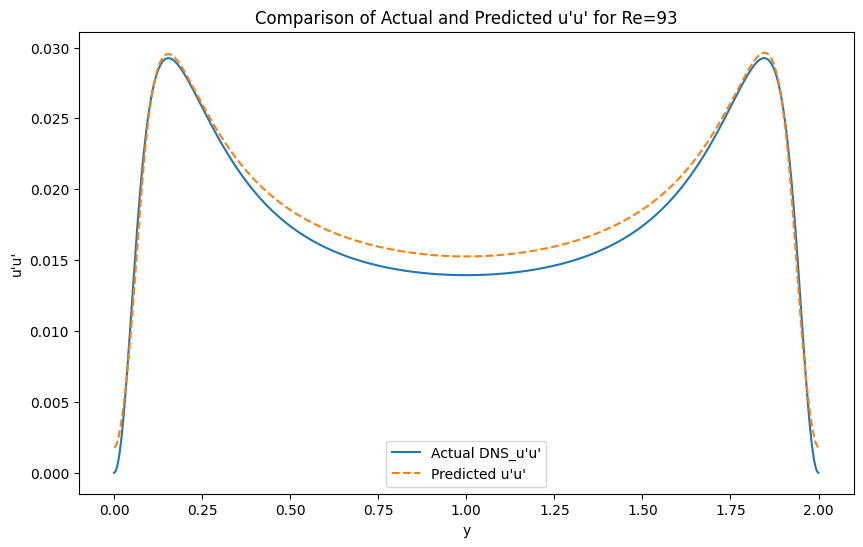

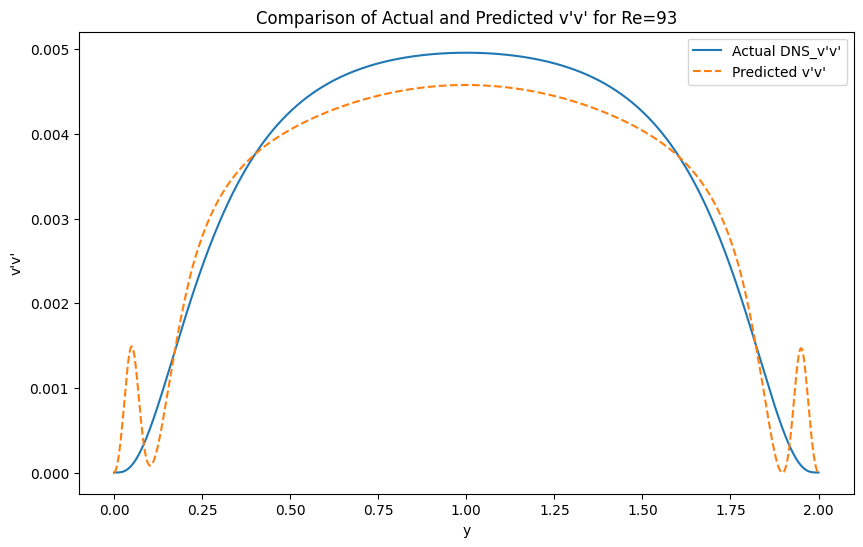

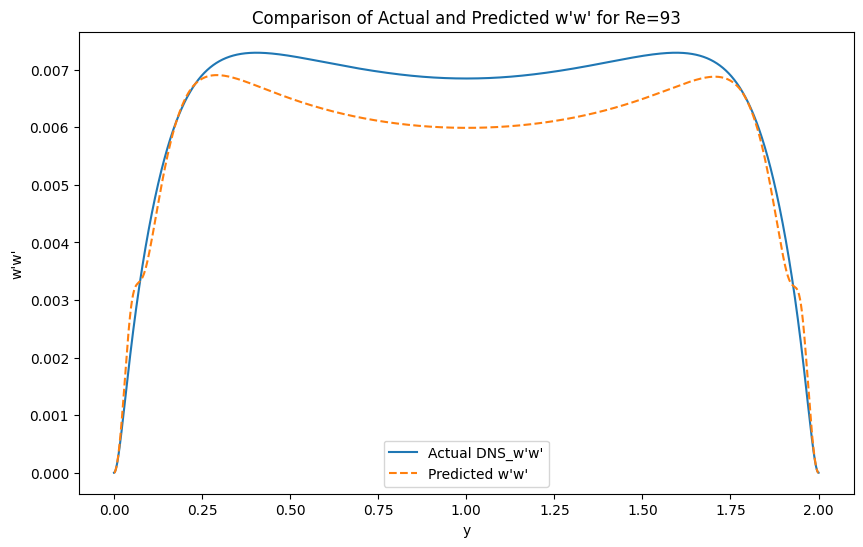

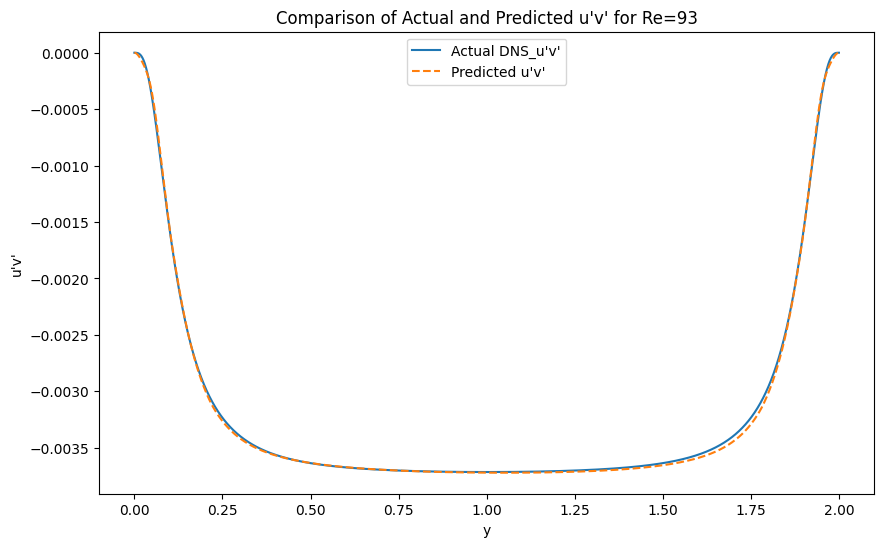

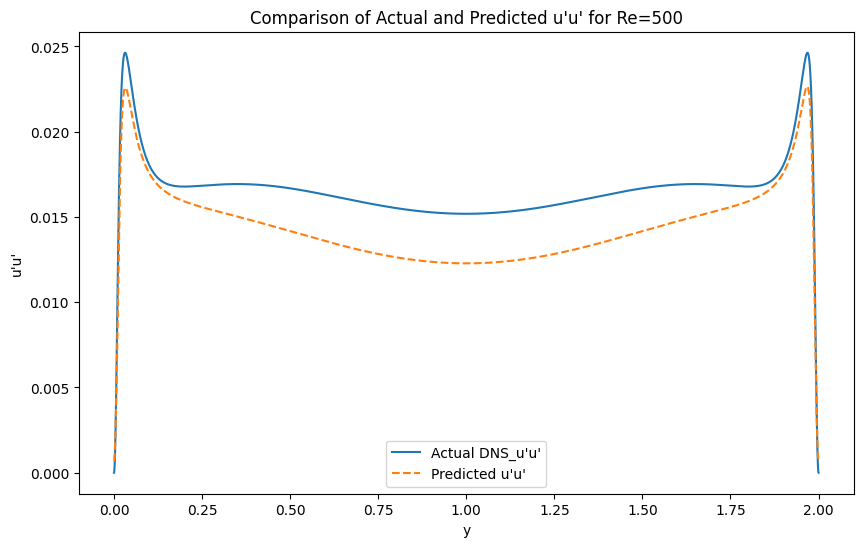

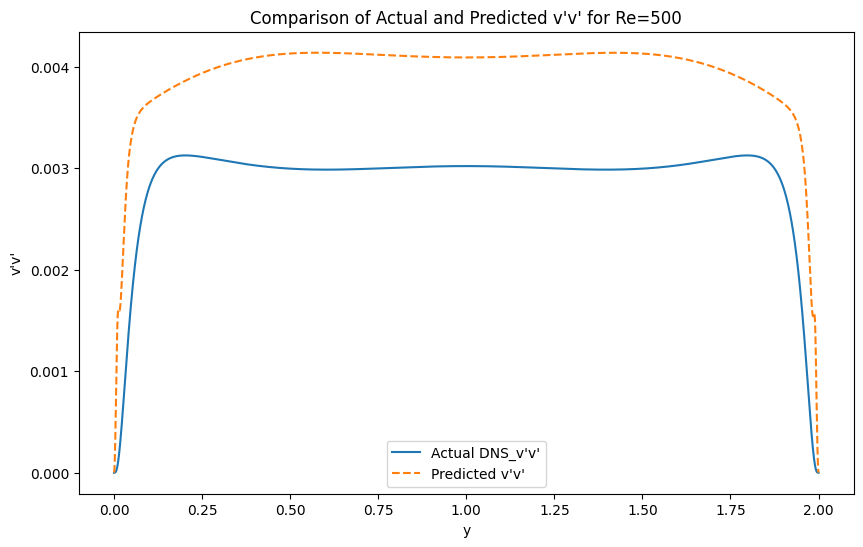

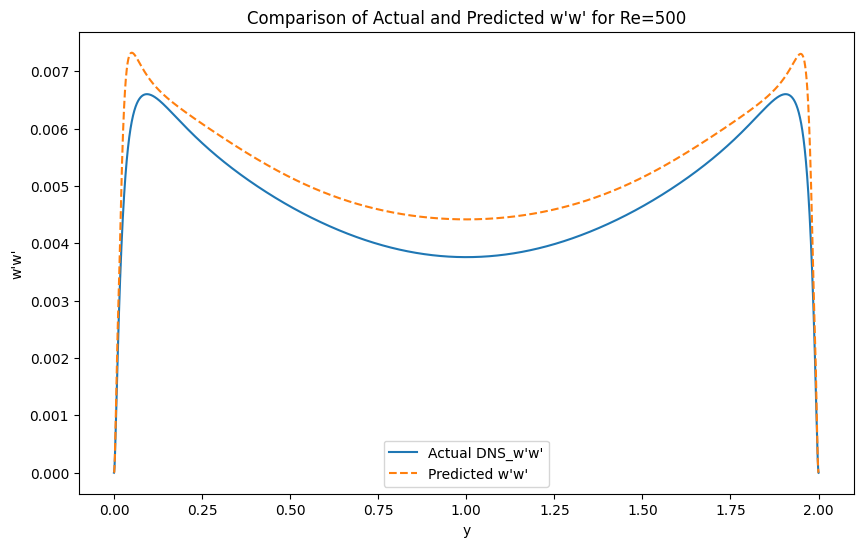

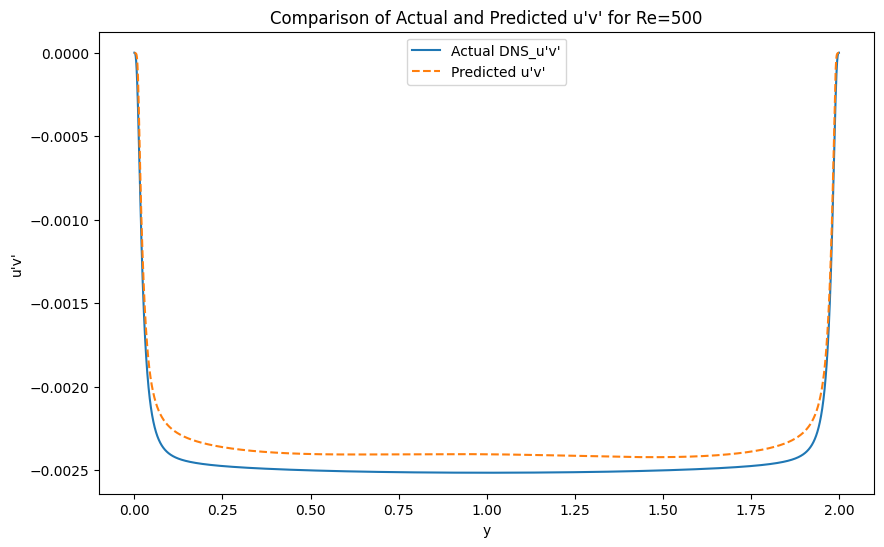

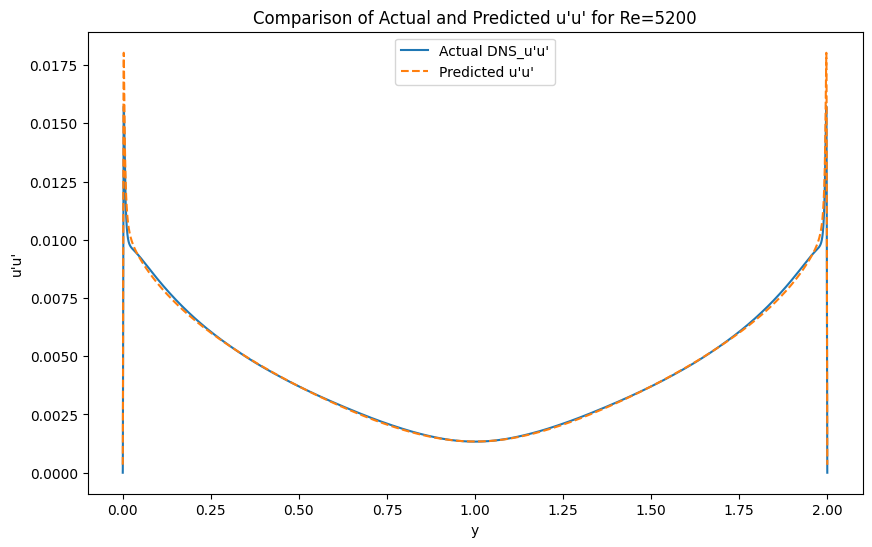

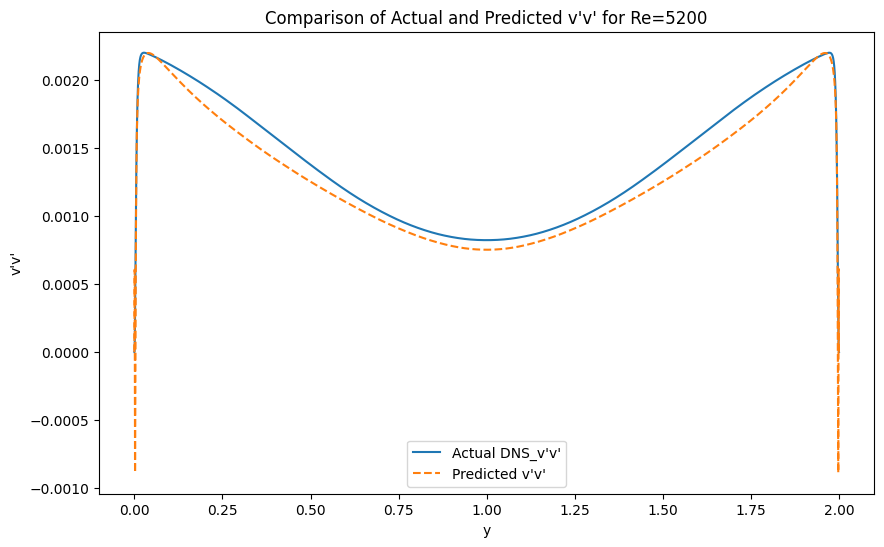

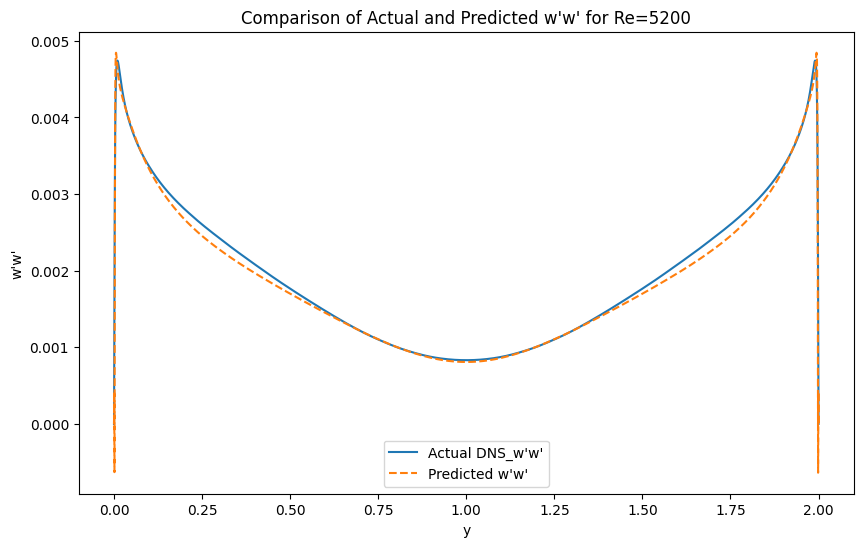

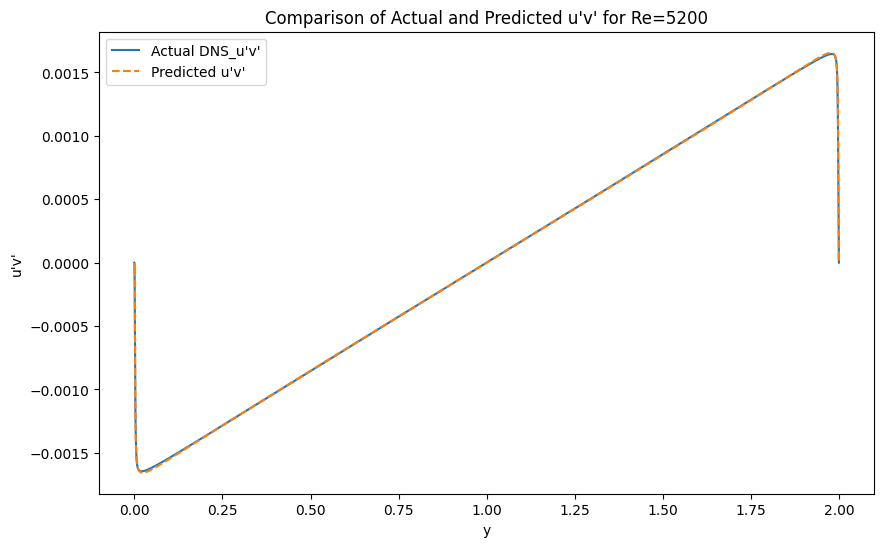

In [8]:
for channel, filename in dns_data_filenames.items():
    dns_data = pd.read_csv(filename)
    t = dns_data['y'].values  # 'y' is the differentiation variable
    
    # Extract features and actual covariances
    X = dns_data[features].values
    X_dot_actual = dns_data[parameters_to_analyze].values
    
    # Predict derivatives using the trained model
    X_dot_predicted = model.predict(X)
    
    # Generate plots for actual vs. predicted derivatives
    for i, var_name in enumerate(parameters_to_analyze):
        plt.figure(figsize=(10, 6))
        plt.plot(t, X_dot_actual[:, i], label=f'Actual DNS_{var_name}')
        plt.plot(t, X_dot_predicted[:, i], label=f'Predicted {var_name}', linestyle='--')
        plt.title(f'Comparison of Actual and Predicted {var_name} for Re={channel}')
        plt.xlabel('y')
        plt.ylabel(var_name)
        plt.legend()
        plt.show()